# Which characteristics are predictive for the income level of a country?

## Data
### World Bank
We took the dataset `world_bank_data.csv` and the corresponding metadata (`world_bank_metadata`) from World Bank.

The data can be found on their website:
- World Bank. World Development Indicators. Publishes online at databank.worldbank.org. Retrieved from: https://databank.worldbank.org/source/world-development-indicators. [Online Resource]. Accessed on 12/26/2021.

### Our World in Data
We took the datasets `cement.csv`, `coal.csv`, `gas.csv` and `oil.csv` from the organisation *Our World in Data*.

The corresponding data can be found in:
- Hannah Ritchie and Max Roser (2020). CO₂ and Greenhouse Gas Emissions. Published online at OurWorldInData.org. Retrieved from: https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions [Online Resource]. Accessed on 12/26/2021.
- Global Carbon Project. (2021). Supplemental data of Global Carbon Budget 2021 (Version 1.0) [Data set]. Global Carbon Project. https://doi.org/10.18160/gcp-2021

## Preparation
### Imports

In [1]:
import pandas as pd
from functools import reduce
import numpy as np
from dataprep.clean import clean_country
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from numpy import mean
from sklearn.tree import export_graphviz
from subprocess import check_call
from sklearn.inspection import permutation_importance

### Helper functions

In [2]:
# Return Pandas Series with the number of NaNs per column in DataFrame
def nans_per_column(df):
    return df.isna().sum()


# Compare Country Code/Country Name MultiIndex in two DataFrames
def compare_multiindex(wb_df, res_df):
    wb_df = wb_df.set_index(['Country Code', 'Country Name'])
    res_df = res_df.set_index(['Country Code', 'Country Name'])
    index1, index2 = wb_df.index, res_df.index
    diff1 = index1.difference(index2).to_frame(index=False)
    diff2 = index2.difference(index1).to_frame(index=False)
    diff1['Belongs to'] = 'Worldbank data'
    diff2['Belongs to'] = 'Resource data'
    diff = pd.concat([diff1, diff2])
    return diff.sort_values(by='Country Code')

### Loading functions

In [3]:
# Load worldbank data
def load_wb():
    wb_data = pd.read_csv('./data/world_bank_data.csv', skipfooter=5, engine='python') # Load world bank data, skip footer to avoid non-data lines in end of file
    return wb_data


# Load resource data (cement, coal, gas, and oil)
def load_resources():
    resources = ['cement', 'coal', 'gas', 'oil']
    
    # Create DFs from all files and merge in an outer join on Entity, Code and Year
    dfs = [pd.read_csv('data/{}.csv'.format(f)) for f in resources]
    res_df = reduce(lambda left,right: pd.merge(left, right, on=['Entity', 'Code', 'Year'], how='outer'), dfs)
    return res_df

### Formatting functions

In [4]:
# Format worldbank data
def format_wb(wb_data):
    df = pd.DataFrame(wb_data)

    # Remove invalid values
    df = df.replace('..', np.nan) 
    
    # Change datatype to numerical
    df["2016 [YR2016]"] = df["2016 [YR2016]"].astype("float")
    df["2017 [YR2017]"] = df["2017 [YR2017]"].astype("float")
    df["2018 [YR2018]"] = df["2018 [YR2018]"].astype("float")
    df["2019 [YR2019]"] = df["2019 [YR2019]"].astype("float")
    
    # Using the last avaiable value for 2019 from the last years
    df.iloc[: , -4:] = df.iloc[: , -4:].interpolate(method='linear', axis='columns')

    # Reformat rows and columns
    df = df.pivot(
        index=['Country Name', 'Country Code'],
        columns='Series Name',
        values='2019 [YR2019]'
    )
    
    # Remove MultiIndex and "Series Name" from df.pivot()
    df = df.reset_index().rename_axis(None, axis=1) 
    return df

# Format resource data
def format_res(res_data):
    df = pd.DataFrame(res_data)
    df = df.rename(columns={"Entity": "Country Name", "Code": "Country Code"})

    # Remove not needed data
    df.drop(df[df.Year < 2016].index, inplace=True)
    df.drop(df[df.Year == 2020].index, inplace=True)
    
    # Change datatype to numerical
    df["Annual CO2 emissions from cement (per capita)"] = df["Annual CO2 emissions from cement (per capita)"].astype("float")
    df["Annual CO2 emissions from coal (per capita)"] = df["Annual CO2 emissions from coal (per capita)"].astype("float")
    df["Annual CO2 emissions from gas (per capita)"] = df["Annual CO2 emissions from gas (per capita)"].astype("float")
    df["Annual CO2 emissions from oil (per capita)"] = df["Annual CO2 emissions from oil (per capita)"].astype("float")

    # Using the last avaiable value for 2019 from the last years
    for i in range(len(df["Country Name"].unique())):
        mask = df.loc[:,"Country Name"]==df["Country Name"].unique()[i]
        df[mask] = df[mask].interpolate(method='linear')
    
    # Remove not needed data
    df.drop(df[df.Year < 2019].index, inplace=True)
    df = df.drop(columns=['Year'])
    
    return df


# Standardize country names according to Dataprep library: https://docs.dataprep.ai/user_guide/clean/clean_country.html
def standardize_countries(unstandard_df):
    df = pd.DataFrame(unstandard_df)
    standard_df = clean_country(df, 'Country Code', report=False)
    standard_df = standard_df[standard_df['Country Code_clean'].notna()]
    standard_df['Country Name'] = standard_df['Country Code_clean']
    standard_df = standard_df.drop(columns='Country Code_clean')
    standard_df = standard_df.set_index('Country Code')
    return standard_df


# # Combine worldbank and resource data
def combine_dfs(wb_df, res_df):
    df = wb_df.merge(res_df, on=['Country Code', 'Country Name'], how='left')
    df.dropna(thresh=20, inplace=True)
    df.fillna(value=0, inplace=True)
    return df.sort_values(by='Country Code')

## Loading and Preprocessing of Data
### Load data from CSV files
World bank data is loaded into a DataFrame from world_bank_data.csv\
Resource data is loaded and combined into a DataFrame from cement.csv, coal.csv, gas.csv, and oil.csv

In [5]:
# Load worldbank data
def load_wb():
    wb_data = pd.read_csv('./data/world_bank_data.csv', skipfooter=5, engine='python') # Load world bank data, skip footer to avoid non-data lines in end of file
    return wb_data

wb_data = load_wb()
wb_data.head()

,Country Name,Country Code,Series Name,Series Code,2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019]
0,Argentina,ARG,Agricultural raw materials exports (% of merch...,TX.VAL.AGRI.ZS.UN,1.06450406584732,1.10594698846639,0.99786070605979,0.88134708952346
1,Argentina,ARG,Agricultural raw materials imports (% of merch...,TM.VAL.AGRI.ZS.UN,0.929774283782705,0.880017998437689,0.891536697840004,1.04566964794435
2,Argentina,ARG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,6.26456582010254,5.23162237725058,4.53787889681146,5.11101651115706
3,Argentina,ARG,Coal rents (% of GDP),NY.GDP.COAL.RT.ZS,7.00203274155281E-05,6.91602190315363E-05,0.000118583173820324,0.000100896618516774
4,Argentina,ARG,Employment in agriculture (% of total employme...,SL.AGR.EMPL.ZS,0.129999995231628,0.0599999986588955,0.100000001490116,0.0599999986588955


In [6]:
# Load resource data (cement, coal, gas, and oil)
def load_resources():
    resources = ['cement', 'coal', 'gas', 'oil']
    
    # Create DFs from all files and merge in an outer join on Entity, Code and Year
    dfs = [pd.read_csv('data/{}.csv'.format(f)) for f in resources]
    res_df = reduce(lambda left,right: pd.merge(left, right, on=['Entity', 'Code', 'Year'], how='outer'), dfs)
    return res_df

res_data = load_resources()
res_data.head()

,Entity,Code,Year,Annual CO2 emissions from cement (per capita),Annual CO2 emissions from coal (per capita),Annual CO2 emissions from gas (per capita),Annual CO2 emissions from oil (per capita)
0,Afghanistan,AFG,1959,0.0021,0.0124,NaN,0.0290
1,Afghanistan,AFG,1960,0.0020,0.0141,NaN,0.0299
2,Afghanistan,AFG,1961,0.0024,0.0192,NaN,0.0320
3,Afghanistan,AFG,1962,0.0031,0.0317,NaN,0.0388
4,Afghanistan,AFG,1963,0.0053,0.0276,NaN,0.0411


### Format data and Standardize Country Names with Dataprep
#### Worldbank data

Missing values from 2019 are interpolated using the values from 2016-2018, then the DataFrame is pivoted to create columns out of the Series Names. Each column value will correspond to the 2019 data for each country.  

In [7]:
# Format worldbank data
def format_wb(wb_data):
    df = pd.DataFrame(wb_data)

    df = df.replace('..', np.nan) 
    df["2016 [YR2016]"] = df["2016 [YR2016]"].astype("float")
    df["2017 [YR2017]"] = df["2017 [YR2017]"].astype("float")
    df["2018 [YR2018]"] = df["2018 [YR2018]"].astype("float")
    df["2019 [YR2019]"] = df["2019 [YR2019]"].astype("float")
    
    df.iloc[: , -4:] = df.iloc[: , -4:].interpolate(method='linear', axis='columns')

    # Reformat rows and columns
    df = df.pivot(
        index=['Country Name', 'Country Code'],
        columns='Series Name',
        values='2019 [YR2019]'
    )
    
    # Remove MultiIndex and "Series Name" from df.pivot()
    df = df.reset_index().rename_axis(None, axis=1) 
    return df

wb_df = format_wb(wb_data)
wb_df.head()

,Country Name,Country Code,Agricultural raw materials exports (% of merchandise exports),Agricultural raw materials imports (% of merchandise imports),"Agriculture, forestry, and fishing, value added (% of GDP)",Coal rents (% of GDP),Employment in agriculture (% of total employment) (modeled ILO estimate),Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Expense (% of GDP),...,Military expenditure (% of GDP),Mineral rents (% of GDP),Natural gas rents (% of GDP),Oil rents (% of GDP),Ores and metals exports (% of merchandise exports),Ores and metals imports (% of merchandise imports),"Physicians (per 1,000 people)","Services, value added (% of GDP)",Total natural resources rents (% of GDP),Trade (% of GDP)
0,Afghanistan,AFG,21.035059,1.769460,25.773971,0.373840,42.500000,18.549999,38.959999,39.220110,...,1.118231,0.000000,0.030681,0.001628,2.199921,1.693842,0.278200,55.472807,0.773957,NaN
1,Africa Eastern and Southern,AFE,1.938509,1.082040,11.526563,0.791680,59.199971,9.421931,31.378323,24.804002,...,1.116059,0.767573,0.119035,2.392536,22.848662,2.796361,0.191352,51.406983,6.046573,52.616912
2,Africa Western and Central,AFW,3.867761,1.214575,21.312182,0.000540,41.658942,12.926183,45.416260,NaN,...,0.871359,0.164029,0.736431,6.488007,2.251041,1.126056,0.236817,47.755318,8.946825,45.608766
3,Albania,ALB,0.492667,0.875030,18.391244,0.024377,36.419998,20.150000,43.430000,23.153042,...,1.291087,0.025324,0.021999,1.353546,3.104336,0.481852,1.647100,48.415497,1.591732,76.287060
4,Algeria,DZA,0.050557,1.064179,12.336212,0.000000,9.600000,30.420000,59.990002,NaN,...,6.021046,0.008143,1.897720,14.394759,0.165401,1.474720,1.719300,46.398727,16.424064,51.841715


#### Resource data
Column names are changed to match Worldbank DataFrame, old data is dropped, and missing values from 2019 are interpolated using the values from 2016-2018.

In [8]:
# Format resource data
def format_res(res_data):
    df = pd.DataFrame(res_data)
    df = df.rename(columns={"Entity": "Country Name", "Code": "Country Code"})
    df.drop(df[df.Year < 2016].index, inplace=True)
    df.drop(df[df.Year == 2020].index, inplace=True)
    
    df["Annual CO2 emissions from cement (per capita)"] = df["Annual CO2 emissions from cement (per capita)"].astype("float")
    df["Annual CO2 emissions from coal (per capita)"] = df["Annual CO2 emissions from coal (per capita)"].astype("float")
    df["Annual CO2 emissions from gas (per capita)"] = df["Annual CO2 emissions from gas (per capita)"].astype("float")
    df["Annual CO2 emissions from oil (per capita)"] = df["Annual CO2 emissions from oil (per capita)"].astype("float")

    for i in range(len(df["Country Name"].unique())):
        mask = df.loc[:,"Country Name"]==df["Country Name"].unique()[i]
        df[mask] = df[mask].interpolate(method='linear')
    
    df.drop(df[df.Year < 2019].index, inplace=True)
    
    df = df.drop(columns=['Year'])
    
    return df

res_df = format_res(res_data)
res_df.head()

,Country Name,Country Code,Annual CO2 emissions from cement (per capita),Annual CO2 emissions from coal (per capita),Annual CO2 emissions from gas (per capita),Annual CO2 emissions from oil (per capita)
60,Afghanistan,AFG,0.0010,0.1980,0.0080,0.1123
153,Africa,NaN,0.0601,0.3553,0.2231,0.4048
225,Albania,ALB,0.2709,0.1907,0.0536,1.1729
313,Algeria,DZA,0.2497,0.0255,2.1470,1.3184
381,Angola,AGO,0.0609,NaN,0.0400,0.3899


#### Standardization of Country Name

Compare country code/name combinations to explore data and manually detect potential inconsistencies.

In [9]:
# Compare Country Code/Country Name MultiIndex in two DataFrames
def compare_multiindex(wb_df, res_df):
    wb_df = wb_df.set_index(['Country Code', 'Country Name'])
    res_df = res_df.set_index(['Country Code', 'Country Name'])
    index1, index2 = wb_df.index, res_df.index
    diff1 = index1.difference(index2).to_frame(index=False)
    diff2 = index2.difference(index1).to_frame(index=False)
    diff1['Belongs to'] = 'Worldbank data'
    diff2['Belongs to'] = 'Resource data'
    diff = pd.concat([diff1, diff2])
    return diff.sort_values(by='Country Code')

diff = compare_multiindex(wb_df, res_df)
diff.head()

,Country Code,Country Name,Belongs to
0,AFE,Africa Eastern and Southern,Worldbank data
1,AFW,Africa Western and Central,Worldbank data
0,AIA,Anguilla,Resource data
2,ARB,Arab World,Worldbank data
3,ASM,American Samoa,Worldbank data


From comparing country codes/names, it is clear that:
- Resource data: Non-country entities have Country Code set to NaN
- Worldbank data: Non-country entities have Country Code set to an inofficial country code
- Country name spelling differs between the two data sets

To standardize the country names and remove non-country entities, the Dataprep library is used. This will filter the NaN/invalid Country Codes and use standardized country name spelling.

In [10]:
# Standardize country names according to Dataprep library: https://docs.dataprep.ai/user_guide/clean/clean_country.html
def standardize_countries(unstandard_df):
    df = pd.DataFrame(unstandard_df)
    standard_df = clean_country(df, 'Country Code', report=False)
    standard_df = standard_df[standard_df['Country Code_clean'].notna()]
    standard_df['Country Name'] = standard_df['Country Code_clean']
    standard_df = standard_df.drop(columns='Country Code_clean')
    standard_df = standard_df.set_index('Country Code')
    return standard_df

std_wb_df = standardize_countries(wb_df)
std_wb_df.head()

  0%|          | 0/8 [00:00<?, ?it/s]

,Country Name,Agricultural raw materials exports (% of merchandise exports),Agricultural raw materials imports (% of merchandise imports),"Agriculture, forestry, and fishing, value added (% of GDP)",Coal rents (% of GDP),Employment in agriculture (% of total employment) (modeled ILO estimate),Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Expense (% of GDP),Exports of goods and services (% of GDP),...,Military expenditure (% of GDP),Mineral rents (% of GDP),Natural gas rents (% of GDP),Oil rents (% of GDP),Ores and metals exports (% of merchandise exports),Ores and metals imports (% of merchandise imports),"Physicians (per 1,000 people)","Services, value added (% of GDP)",Total natural resources rents (% of GDP),Trade (% of GDP)
Country Code,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,21.035059,1.769460,25.773971,0.373840,42.500000,18.549999,38.959999,39.220110,NaN,...,1.118231,0.000000,0.030681,0.001628,2.199921,1.693842,0.2782,55.472807,0.773957,NaN
ALB,Albania,0.492667,0.875030,18.391244,0.024377,36.419998,20.150000,43.430000,23.153042,31.307498,...,1.291087,0.025324,0.021999,1.353546,3.104336,0.481852,1.6471,48.415497,1.591732,76.287060
DZA,Algeria,0.050557,1.064179,12.336212,0.000000,9.600000,30.420000,59.990002,NaN,22.713462,...,6.021046,0.008143,1.897720,14.394759,0.165401,1.474720,1.7193,46.398727,16.424064,51.841715
ASM,American Samoa,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,61.574074,...,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,156.327160
AND,Andorra,1.520253,0.394203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,3.213029,0.453707,NaN,NaN,0.000000,NaN


In [11]:
std_res_df = standardize_countries(res_df)
std_res_df.head()

  0%|          | 0/8 [00:00<?, ?it/s]

,Country Name,Annual CO2 emissions from cement (per capita),Annual CO2 emissions from coal (per capita),Annual CO2 emissions from gas (per capita),Annual CO2 emissions from oil (per capita)
Country Code,,,,,
AFG,Afghanistan,0.0010,0.1980,0.0080,0.1123
ALB,Albania,0.2709,0.1907,0.0536,1.1729
DZA,Algeria,0.2497,0.0255,2.1470,1.3184
AGO,Angola,0.0609,NaN,0.0400,0.3899
ARG,Argentina,0.0915,0.0577,2.0520,1.4995


### Combine datasets
Worldbank and Resource DataFrames are merged on Country Name and Country Code. Entities with a large number of NaNs are removed, as these belong to countries with too few values to work with.

In [12]:
# Combine worldbank and resource data
def combine_dfs(wb_df, res_df):
    df = wb_df.merge(res_df, on=['Country Code', 'Country Name'], how='left')
    df.dropna(thresh=20, inplace=True)
    df.fillna(value=0, inplace=True)
    return df.sort_values(by='Country Code')

comb_df = combine_dfs(std_wb_df, std_res_df)
comb_df.head()

,Country Name,Agricultural raw materials exports (% of merchandise exports),Agricultural raw materials imports (% of merchandise imports),"Agriculture, forestry, and fishing, value added (% of GDP)",Coal rents (% of GDP),Employment in agriculture (% of total employment) (modeled ILO estimate),Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Expense (% of GDP),Exports of goods and services (% of GDP),...,Ores and metals exports (% of merchandise exports),Ores and metals imports (% of merchandise imports),"Physicians (per 1,000 people)","Services, value added (% of GDP)",Total natural resources rents (% of GDP),Trade (% of GDP),Annual CO2 emissions from cement (per capita),Annual CO2 emissions from coal (per capita),Annual CO2 emissions from gas (per capita),Annual CO2 emissions from oil (per capita)
Country Code,,,,,,,,,,,,,,,,,,,,,
ABW,Aruba,0.097893,0.349028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.799397,...,5.306358,1.078625,0.0000,0.000000,0.002860,148.425802,0.0000,0.0000,0.0000,8.0063
AFG,Afghanistan,21.035059,1.769460,25.773971,0.373840,42.500000,18.549999,38.959999,39.220110,0.000000,...,2.199921,1.693842,0.2782,55.472807,0.773957,0.000000,0.0010,0.1980,0.0080,0.1123
AGO,Angola,0.056133,0.936210,6.660704,0.000000,50.730000,6.800000,42.470001,15.513042,39.343826,...,3.532148,0.701040,0.2146,38.850346,26.194267,64.288579,0.0609,0.0000,0.0400,0.3899
ALB,Albania,0.492667,0.875030,18.391244,0.024377,36.419998,20.150000,43.430000,23.153042,31.307498,...,3.104336,0.481852,1.6471,48.415497,1.591732,76.287060,0.2709,0.1907,0.0536,1.1729
ARE,United Arab Emirates,0.051911,0.431989,0.747178,0.000000,1.390000,34.220001,64.389999,4.267227,96.843533,...,3.773348,2.892962,2.5278,54.793158,16.756620,167.694153,0.8937,0.7665,12.0901,1.9153


## Data Exploration
### Check for null values
The goal of data preparation was to fill or remove the null values. This was made to enable further processing and, ultimately, training of the model.

In [13]:
# Return Pandas Series with the number of NaNs per column in DataFrame
def nans_per_column(df):
    return df.isna().sum()

nans_per_column(comb_df)

Country Name                                                                    0
Agricultural raw materials exports (% of merchandise exports)                   0
Agricultural raw materials imports (% of merchandise imports)                   0
Agriculture, forestry, and fishing, value added (% of GDP)                      0
Coal rents (% of GDP)                                                           0
Employment in agriculture (% of total employment) (modeled ILO estimate)        0
Employment in industry (% of total employment) (modeled ILO estimate)           0
Employment in services (% of total employment) (modeled ILO estimate)           0
Expense (% of GDP)                                                              0
Exports of goods and services (% of GDP)                                        0
Food exports (% of merchandise exports)                                         0
Food imports (% of merchandise imports)                                         0
Forest area (% o

### Search for outliers
During the exploration phase we examined all the different attributes in the following way. The outliers were searched in the first step with boxplots. An outlier is defined as a data point that is located outside the whiskers of the boxplot. There was no negative or left-hand outliers. The maximum of the box plot is defined as Q3+1.5\*IQR. For visualisation purposes we only generate the boxplot for one attribute in the following.

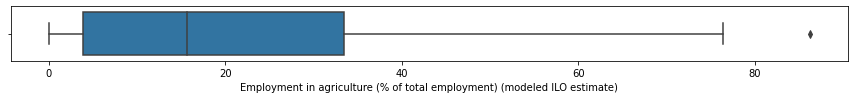

In [14]:
outliers=comb_df.select_dtypes(exclude=['object'])[['Employment in agriculture (% of total employment) (modeled ILO estimate)']]

for column in outliers:
        plt.figure(figsize=(15,1))
        sns.boxplot(data=outliers, x=column)
        plt.close

### Check the outliers
After examining the boxplots the "outliers" were printed (and controlled) with the "value > Q3+1.5\*IQR" formula. In case there were still too many datapoints we used a bigger multiplier, if there weren't any datapoint a subtraction was used with a smaller multiplier (e.g. "value > Q3-0.5\*IQR") to still be able to check the biggest values.


In [15]:
Q1 = comb_df['Employment in agriculture (% of total employment) (modeled ILO estimate)'].quantile(0.25)
Q3 = comb_df['Employment in agriculture (% of total employment) (modeled ILO estimate)'].quantile(0.75)
IQR = Q3 - Q1
 
print(comb_df[['Employment in agriculture (% of total employment) (modeled ILO estimate)']].loc[comb_df['Employment in agriculture (% of total employment) (modeled ILO estimate)'] >= Q3 + 1.5*IQR])

              Employment in agriculture (% of total employment) (modeled ILO estimate)
Country Code                                                                          
BDI                                                   86.209999                       


After examining the values we ageed on the "outliers" are explainable with common sense, or the values could be (apprx.) verified by other sources too. Therefore, we accepted them since they are not sensor / measured, but more "reliable" data.

### Explore the Distributions
In the following, the distribution of the output variable is plotted. It can be seen that the distribution is very skewed. We might therefore have problems correctly prediction higher GNI values as the majority of values is between 0 and 20 000.

We also took the time to plot the different attributes. We used the *skew()* function of scipy, which measures the skewness of the data. We plotted the histograms for data with a skewness of >= 4.
It can be seen that a lot of attribute values are skewed as well and only few resemble somehting close to a normal distribution.

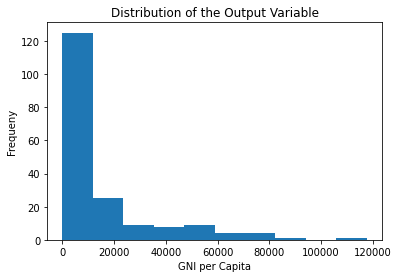

Skewness: 5.509249300109476


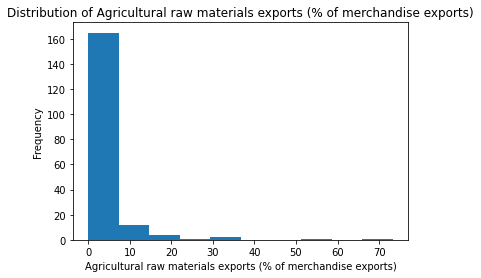

Skewness: 9.426280740708705


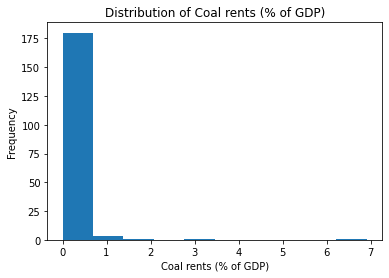

Skewness: 6.869169855727061


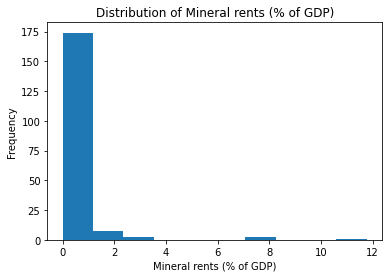

Skewness: 7.785295894732313


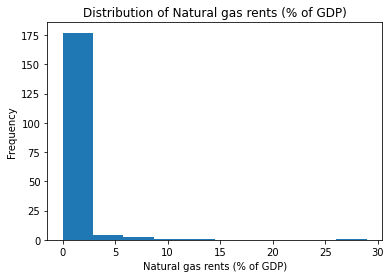

Skewness: 6.844937176691794


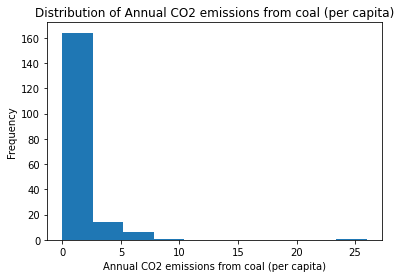

Skewness: 5.268458804709175


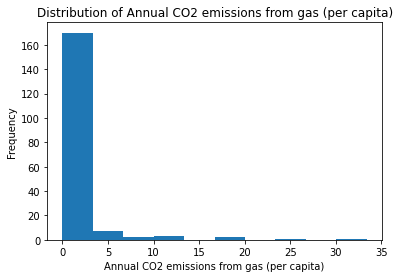

In [16]:
plt.hist(comb_df["GNI per capita, Atlas method (current US$)"])
plt.title("Distribution of the Output Variable")
plt.xlabel("GNI per Capita")
plt.ylabel("Frequeny")
plt.show()

for i in comb_df.columns:
    if i == "Country Name":
        continue
    if skew(comb_df[i]) >= 4:
        print("Skewness:",skew(comb_df[i]))
        plt.hist(comb_df[i])
        plt.xlabel(i)
        plt.ylabel("Frequency")
        plt.title("Distribution of {}".format(i))
        plt.show()

### Correlation of Variables
In the following, a correlation plot is generated, using all attributes with a correlation bigger or equal 0.75.

The following can be observed:
- Coal Rents and Annual CO2 emissions from coal highly correlate (0.76) with each other. This can, however, be expected as they describe a similar variable.
- Exports and Imports of Goods have a high correlation with each other (which can be expected too). **However, there is an even higher correlation with the trade variable, which is why we removed it ultimately (with a correlation of 0.98 and 0.97 respectively, there is hardly any added information)**.
- Fuel exports and Oil rents correlate with each other. This was expected too as fuel exports depend on oil.
- Moreover, Oil rents and total natural resources rents highly correlate with each other (0.92). **This and the high correlation with Fuel exports led to us removing the Oil rents from the dataset**.
- ICT (Information and communications technology) exports and imports correlate highly.
- And lastly, the export and manufacturing of medium and high-tec products correlate with a factor of 0.78 too.

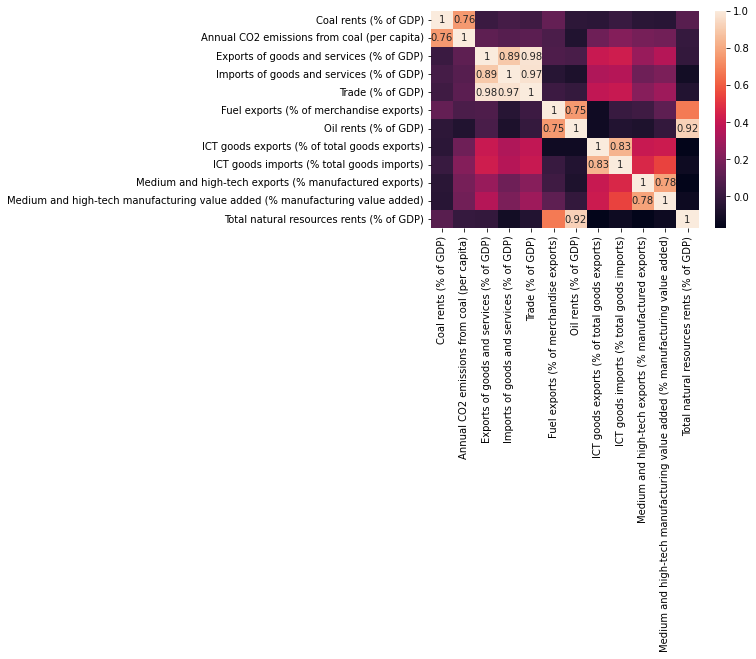

In [17]:
cor = comb_df.corr()

high_cor = []
for i in range(0,cor.shape[0]):
    for j in range(0,cor.shape[1]):
        # get correlation > 0.75
        if cor.iloc[i, j] >= 0.75 and i != j:
            if i not in high_cor:
                high_cor.append(i)
            if j not in high_cor:
                high_cor.append(j)

df = pd.DataFrame()
for i in high_cor:
    df = df.append(comb_df[cor.columns[i]])

# annotate only correlation > 0.75
ax = sns.heatmap(df.transpose().corr(), annot=True)
for text in ax.texts:
    if float(text.get_text())>=0.75:
        text.set_text(text.get_text())
    else:
        text.set_text("")

## Machine Learning
In the following, we first delete the non-predictive attribute *Country Name*. As described in the previous steps, due to high correlation, we have also decided to trop the *Trade* and *Oil rents* variable.

We then split the data into an input and output data frame (the output variable being *GNI per capita*). Afterwards we split the data again into a training and test set. The training set will be used to fit a ML model and the test set will be used in the end to again test the configuration with a completely independent test set.

Additionally, we scale the data using two different approaches, namely MinMaxScaling and  Standard Scaling. The two approaches will be compared later on to find the optimal scaling technique.

In [18]:
del comb_df["Country Name"]

del comb_df["Trade (% of GDP)"]
del comb_df["Oil rents (% of GDP)"]

y = comb_df["GNI per capita, Atlas method (current US$)"]
X = comb_df.loc[:, comb_df.columns != "GNI per capita, Atlas method (current US$)"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=987, shuffle=True)

scaler = MinMaxScaler()
X_train_min_max = scaler.fit_transform(X_train)
X_test_min_max = scaler.transform(X_test)

scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

### Linear Regression
In the following, we use linear regression to assess whether the data is linearly separable or not. We use all input datasets (not scaled, MinMax scaled and Standard scaled) to train the models. For each model, we save the regression coefficients to analyse the realtive importance of the variables.

Altogether, it can be seen that the models return very similar RMSE values. Therfore, scaling the data did not make a big difference in this setting. We can also conclude that the data does not seem to be linear separable and we have to turn to different algorithms to find better model fits.

Moreover, we printed the respective model coefficients, which led to the following insights. All three models returned completely different regression coefficients, which is why they are hard to compare. It is hardly possible to make up assumptions about rather insignificant variables throughout all models. Therefore, this had to be decided for each model separately.

Nevetheless, the following three variables have the least impact on the output throughout all models.
- Expense (% of GDP)
- ICT goods imports
- Annual CO2 emissions from gas

RMSE: 20237.559872223643


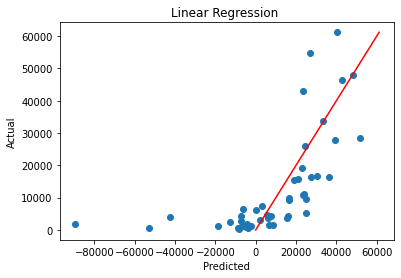

RMSE: 20237.5598722236


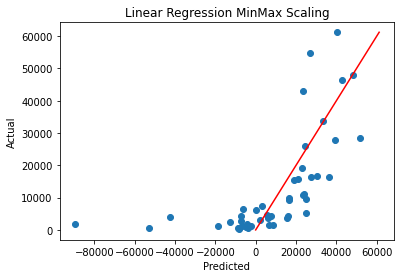

RMSE: 20237.55987222364


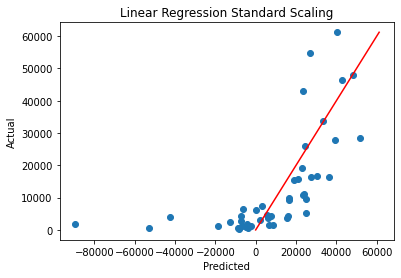

                                 No Scaling  MinMax Scaling  Standard Scaling
Agricultural raw materials exp   -57.448961    -4210.418989       -461.865592
Agricultural raw materials imp  -631.930171    -3176.043893       -563.673924
Agriculture, forestry, and fis    85.035045     3382.162135        786.311982
Coal rents (% of GDP)          -2054.941698    -7004.782965       -723.001589
Employment in agriculture (% o  -257.900266   -18708.085521      -5227.381649
Employment in industry (% of t  -684.377932   -27258.774268      -5635.065450
Employment in services (% of t    78.523762     7062.427358       1584.615876
Expense (% of GDP)                -5.406669     -436.397915        -80.638266
Exports of goods and services    389.046105    79942.001900      12412.755242
Food exports (% of merchandise  -132.439860   -13149.309538      -2913.252845
Food imports (% of merchandise   165.404579     6465.891002       1306.842468
Forest area (% of land area)     -86.839769    -8466.059182     

In [19]:
datasets = {"":[X_train,X_test], "MinMax Scaling":[X_train_min_max,X_test_min_max], "Standard Scaling":[X_train_standard,X_test_standard]}
coefs = []

for label, data in datasets.items():
    model = LinearRegression()
    model.fit(data[0], y_train)

    pred = model.predict(data[1])

    coefs.append(model.coef_)

    print("RMSE:", mean_squared_error(y_test, pred, squared=False))

    x = range(0,int(max(y_test)))
    plt.scatter(pred, y_test)
    plt.title("Linear Regression {}".format(label))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.plot(x,x, color="red")
    plt.show()

coefs = pd.DataFrame(coefs).transpose()
coefs.index = X_train.columns.str[0:30]
coefs.columns = ["No Scaling","MinMax Scaling","Standard Scaling"]
print(coefs)

### Cross-Validation
As Linear Regression did not lead to satisfactory results, we decided to go with different Regression models. In the following, we implement a 5-Fold Cross-Validation to test and compare a RandomForestRegressor, KNeighborsRegressor, Lasso Regression and a Support Vector Regression.

We split the data into another training and validation set in the beginning and train the model (and fit the Grid Search) on the training set. We then store the RMSE on the validation set.

In the end, the best model is determined by the mean RMSE from the Cross-Validation.

In [20]:
kf = KFold(n_splits=5, random_state=123, shuffle=True)

rf_min_max = []
knn_min_max = []
lasso_min_max = []
svr_min_max = []

rf_standard = []
knn_standard = []
lasso_standard = []
svr_standard = []

for train_index, test_index in kf.split(X_train):
    X_train_kf_min_max, X_test_kf_min_max = X_train_min_max[train_index,], X_train_min_max[test_index,]
    X_train_kf_standard, X_test_kf_standard = X_train_standard[train_index,], X_train_standard[test_index,]
    y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]

    params = {"n_estimators":[25,50,75,100,125], "criterion":["squared_error","absolute_error","poisson"],
              "min_samples_leaf":[1,3,5,7]}

    model = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params)
    model.fit(X_train_kf_min_max, y_train_kf)
    pred = model.predict(X_test_kf_min_max)
    rf_min_max.append(mean_squared_error(y_test_kf, pred, squared=False))

    model = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params)
    model.fit(X_train_kf_standard, y_train_kf)
    pred = model.predict(X_test_kf_standard)
    rf_standard.append(mean_squared_error(y_test_kf, pred, squared=False))

    params = {"n_neighbors":[1,3,5,7,9,11], "weights":["uniform","distance"],"algorithm":["ball_tree","kd_tree","brute"]}

    model = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params)
    model.fit(X_train_kf_min_max, y_train_kf)
    pred = model.predict(X_test_kf_min_max)
    knn_min_max.append(mean_squared_error(y_test_kf, pred, squared=False))

    model = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params)
    model.fit(X_train_kf_standard, y_train_kf)
    pred = model.predict(X_test_kf_standard)
    knn_standard.append(mean_squared_error(y_test_kf, pred, squared=False))

    params = {"alpha":[1,10,100,1000,10000, 100000]}

    model = GridSearchCV(estimator=Lasso(max_iter=10000), param_grid=params)
    model.fit(X_train_kf_min_max, y_train_kf)
    pred = model.predict(X_test_kf_min_max)
    lasso_min_max.append(mean_squared_error(y_test_kf, pred, squared=False))

    model = GridSearchCV(estimator=Lasso(max_iter=10000), param_grid=params)
    model.fit(X_train_kf_standard, y_train_kf)
    pred = model.predict(X_test_kf_standard)
    lasso_standard.append(mean_squared_error(y_test_kf, pred, squared=False))

    params = [
            {"kernel":
                 ["linear"],
             "C": [0.001, 0.1, 1, 10, 100]},
            {"kernel":
                 ["poly"],
             "degree": [2, 3, 4, 5, 6, 7, 8],
             "C": [0.001, 0.1, 1, 10, 100]},
            {"kernel":
                 ["rbf"],
             "gamma": ["auto", "scale"],
             "C": [0.001, 0.1, 1, 10, 100]}
        ]

    model = GridSearchCV(estimator=SVR(), param_grid=params)
    model.fit(X_train_kf_min_max, y_train_kf)
    pred = model.predict(X_test_kf_min_max)
    svr_min_max.append(mean_squared_error(y_test_kf, pred, squared=False))

    model = GridSearchCV(estimator=SVR(), param_grid=params)
    model.fit(X_train_kf_standard, y_train_kf)
    pred = model.predict(X_test_kf_standard)
    svr_standard.append(mean_squared_error(y_test_kf, pred, squared=False))

print("Mean RMSE Random Forest with MinMaxScaler:",mean(rf_min_max))
print("Mean RMSE Random Forest with StandardScaler:",mean(rf_standard))
print("Mean RMSE K-Nearest Neighbors with MinMaxScaler:",mean(knn_min_max))
print("Mean RMSE K-Nearest Neighbors with StandardScaler:",mean(knn_standard))
print("Mean RMSE SVR with MinMaxScaler:",mean(svr_min_max))
print("Mean RMSE SVR with StandardScaler:",mean(svr_standard))
print("Mean RMSE Lasso with MinMaxScaler:",mean(lasso_min_max))
print("Mean RMSE Lasso with StandardScaler:",mean(lasso_standard))

Mean RMSE Random Forest with MinMaxScaler: 11764.506471202185
Mean RMSE Random Forest with StandardScaler: 13395.325253488636
Mean RMSE K-Nearest Neighbors with MinMaxScaler: 14670.249219888306
Mean RMSE K-Nearest Neighbors with StandardScaler: 16625.063703397864
Mean RMSE SVR with MinMaxScaler: 15032.915800608363
Mean RMSE SVR with StandardScaler: 15805.243588328467
Mean RMSE Lasso with MinMaxScaler: 14913.802966246183
Mean RMSE Lasso with StandardScaler: 13590.115493865009


### Final Fitting of the Model
In the following, we determine the best model and scaling and train it once again with the training data. The configuration is then tested on the independent test set.

Finally, the results are printed. Here, we used multiple different evaluation methods to be able further analyse the results.

What can evidently be observed is that (as already discussed in the exloration section with the distribution of the output variable) the model is able to accurately predict lower GNI values. In contrast, it has a lot more difficulties predicting the GNI values of countries with a higher income level.

Based on the results of the final model, we can make the following observations.
- The RMSE value of the Model is very high, given that the predictions for higher GNI values were quite inaccurate
- Therefore, the maximum error is very high as well, as well as the mean error
- Still, it can be seen that the median error was not too high and the predictions where, at least for smaller GNI values, quite accurate

Best Model: Random Forest Regressor
Final Hyper-Parameters: {'criterion': 'absolute_error', 'min_samples_leaf': 3, 'n_estimators': 75}
RMSE: 10473.221551759796
Exlained Variance: 0.5597928858095078
Max Error: 34088.66666666667
Mean Absolute Error: 6195.449645390071
Median Absolute Error: 2092.533333333333


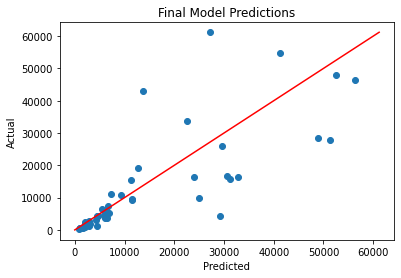

In [21]:
if mean(rf_min_max) < min(mean(rf_standard),mean(svr_min_max),mean(svr_standard),mean(lasso_min_max),mean(lasso_standard),
                          mean(knn_min_max),mean(knn_standard)):
    print("Best Model:","Random Forest Regressor")
    params = {"n_estimators":[25,50,75,100,125], "criterion":["squared_error","absolute_error","poisson"],
              "min_samples_leaf":[1,3,5,7]}

    model = GridSearchCV(estimator=RandomForestRegressor(random_state=123), param_grid=params)
    model.fit(X_train_min_max, y_train)
    pred = model.predict(X_test_min_max)
elif mean(rf_standard) < min(mean(svr_min_max),mean(svr_standard),mean(lasso_min_max),mean(lasso_standard),
                          mean(knn_min_max),mean(knn_standard)):
    print("Best Model:","Random Forest Regressor")
    params = {"n_estimators":[25,50,75,100,125], "criterion":["squared_error","absolute_error","poisson"],
              "min_samples_leaf":[1,3,5,7]}

    model = GridSearchCV(estimator=RandomForestRegressor(random_state=123), param_grid=params)
    model.fit(X_train_standard, y_train)
    pred = model.predict(X_test_standard)
elif mean(svr_min_max) < min(mean(svr_standard),mean(lasso_min_max),mean(lasso_standard),
                          mean(knn_min_max),mean(knn_standard)):
    print("Best Model:","Support Vector Regression")
    params = [
            {"kernel":
                 ["linear"],
             "C": [0.001, 0.1, 1, 10, 100]},
            {"kernel":
                 ["poly"],
             "degree": [2, 3, 4, 5, 6, 7, 8],
             "C": [0.001, 0.1, 1, 10, 100]},
            {"kernel":
                 ["rbf"],
             "gamma": ["auto", "scale"],
             "C": [0.001, 0.1, 1, 10, 100]}
        ]

    model = GridSearchCV(estimator=SVR(), param_grid=params)
    model.fit(X_train_min_max, y_train)
    pred = model.predict(X_test_min_max)
elif mean(svr_standard) < min(mean(lasso_min_max),mean(lasso_standard),
                          mean(knn_min_max),mean(knn_standard)):
    print("Best Model:","Support Vector Regression")
    params = [
            {"kernel":
                 ["linear"],
             "C": [0.001, 0.1, 1, 10, 100]},
            {"kernel":
                 ["poly"],
             "degree": [2, 3, 4, 5, 6, 7, 8],
             "C": [0.001, 0.1, 1, 10, 100]},
            {"kernel":
                 ["rbf"],
             "gamma": ["auto", "scale"],
             "C": [0.001, 0.1, 1, 10, 100]}
        ]

    model = GridSearchCV(estimator=SVR(), param_grid=params)
    model.fit(X_train_standard, y_train)
    pred = model.predict(X_test_standard)
elif mean(lasso_min_max) < min(mean(lasso_standard),
                          mean(knn_min_max),mean(knn_standard)):
    print("Best Model:","Lasso")
    params = {"alpha":[1,10,100,1000,10000, 100000]}
    model = GridSearchCV(estimator=Lasso(max_iter=10000), param_grid=params)
    model.fit(X_train_min_max, y_train)
    pred = model.predict(X_test_min_max)
elif mean(lasso_standard) < min(
                          mean(knn_min_max),mean(knn_standard)):
    print("Best Model:","Lasso")
    params = {"alpha":[1,10,100,1000,10000, 100000]}
    model = GridSearchCV(estimator=Lasso(max_iter=10000), param_grid=params)
    model.fit(X_train_standard, y_train)
    pred = model.predict(X_test_standard)
elif mean(knn_min_max) < mean(knn_standard):
    print("Best Model:","K-Nearest Neighbor Regressor")
    params = {"n_neighbors":[1,3,5,7,9,11], "weights":["uniform","distance"],"algorithm":["ball_tree","kd_tree","brute"]}
    model = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params)
    model.fit(X_train_min_max, y_train)
    pred = model.predict(X_test_min_max)
else:
    print("Best Model:","K-Nearest Neighbor Regressor")
    params = {"n_neighbors":[1,3,5,7,9,11], "weights":["uniform","distance"],"algorithm":["ball_tree","kd_tree","brute"]}
    model = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=params)
    model.fit(X_train_standard, y_train)
    pred = model.predict(X_test_standard)


print("Final Hyper-Parameters:", model.best_params_)
print("RMSE:", mean_squared_error(y_test, pred, squared=False))
print("Exlained Variance:", explained_variance_score(y_test,pred))
print("Max Error:", max_error(y_test, pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, pred))
print("Median Absolute Error:", median_absolute_error(y_test, pred))

x = range(0,int(max(y_test)))
plt.scatter(pred, y_test)
plt.title("Final Model Predictions")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.plot(x,x, color="red")
plt.show()

## Analysis of Results
### Feature Importance
Below, we used feature permutation to retrieve the feature importances of the attributes.

It can be observed that there are a lot of attributes, which hardly important and only few highly contributing ones. In the following, we rank the features based on their importance.
1. Employment in Agriculture
2. Employment in Services
3. Annual CO2 emissions from coal
4. Phyisicians per 1000 people
5. Annual CO2 emissions from oil
6. Medium and high-tech manufacturing value added
7. Expense
8. ICT goods exports
9. Annual CO2 emissions from gas

c:\users\brini\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


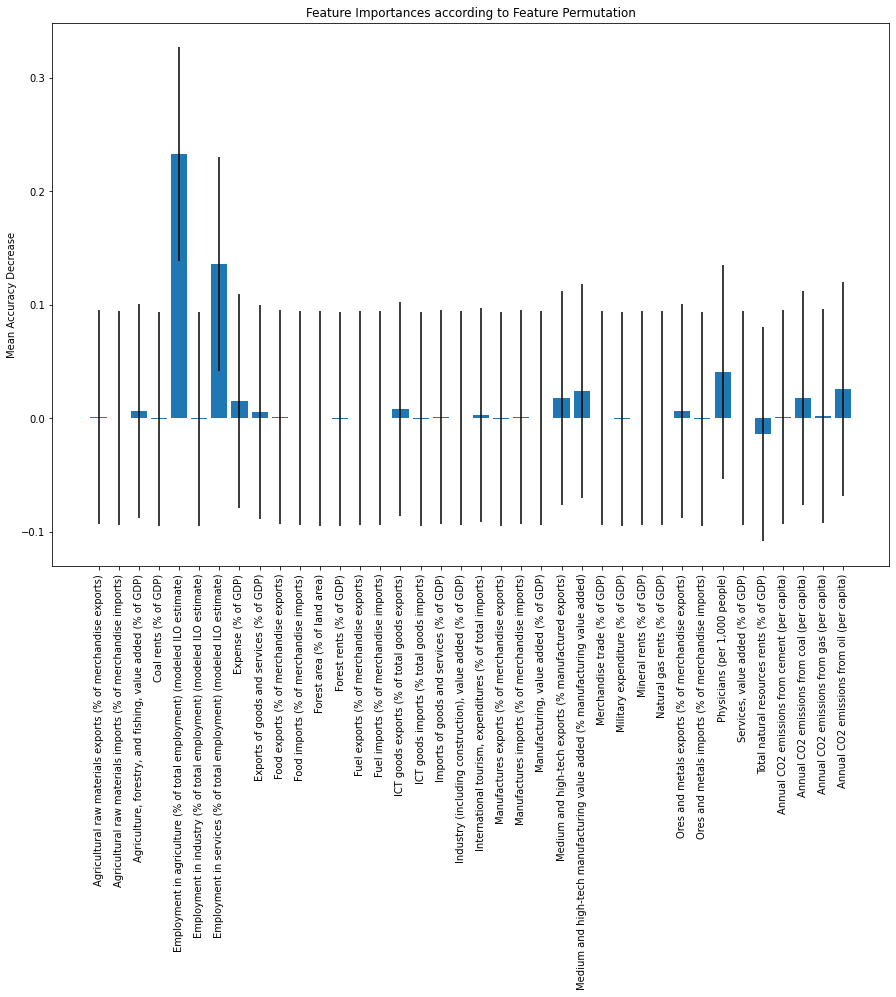

In [22]:
rf = model.best_estimator_
importances = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=123, n_jobs=-1).importances_mean
std = np.std([tree.feature_importances_ for tree in rf.estimators_])

plt.figure(figsize=(15,10))
plt.bar(X.columns, importances, yerr=std)
plt.title("Feature Importances according to Feature Permutation")
plt.ylabel("Mean Accuracy Decrease")
plt.xticks(rotation=90)
plt.show()

### Visualisation of Some Decision Trees
We generated some visualisations of the decision trees. They are too big, however, to include them in the notebook. You can find the generated .png files in the *trees* directory.

We believe that it is interesting to take a further look at certain decision boundaries to check, which values for the respective attributes give an idea on the GNI value of the country.
- What can be observed when looking at the different decision boundaries for Employment in Agriculture is that 0.1 seems to play an important role. We plotted the two variables against each other below. This explains the high importance of the attribute.
- When looking at the decision boundary for Employment in services, the line is not as clear as for agriculture, but the decision boundaries usually range from 0.7-0.9 (70% - 90%). When looking at the scatterplot, this is also not surprising.
- Another interesting insights is that the CO2 emissions from oil decision boundary is usually about 0.0 to 0.1. The scatterplot reveals that countries with a lower CO2 emission from oil value have a much lower GNI value as well.

The other variables do not provide a very clear separation between low- and high GNI value countries.

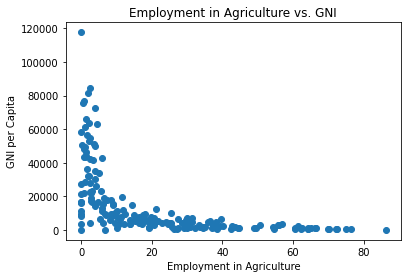

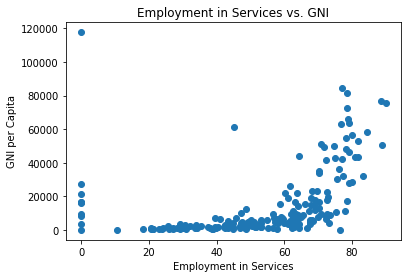

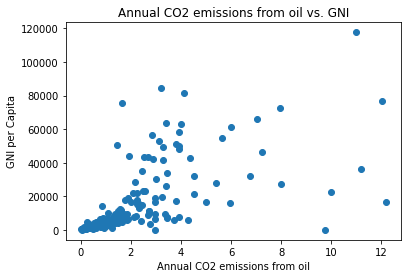

In [23]:
for i in [1,3,5,7,9,13,19,21,25,28,33,45]:
    export_graphviz(model.best_estimator_.estimators_[i], out_file="trees/vis_{}.dot".format(i), feature_names=X_train.columns, rounded=True,
                    precision=True, filled=True)
    check_call(['dot', '-Tpng', 'trees/vis_{}.dot'.format(i), '-o', 'trees/vis_{}.png'.format(i)],shell=True)

    #img = image.imread("trees/vis_{}.png".format(i))
    #plt.imshow(img)
    #plt.show()

plt.scatter(comb_df["Employment in agriculture (% of total employment) (modeled ILO estimate)"],
            comb_df["GNI per capita, Atlas method (current US$)"])
plt.title("Employment in Agriculture vs. GNI")
plt.xlabel("Employment in Agriculture")
plt.ylabel("GNI per Capita")
plt.show()

plt.scatter(comb_df["Employment in services (% of total employment) (modeled ILO estimate)"],
            comb_df["GNI per capita, Atlas method (current US$)"])
plt.title("Employment in Services vs. GNI")
plt.xlabel("Employment in Services")
plt.ylabel("GNI per Capita")
plt.show()

plt.scatter(comb_df["Annual CO2 emissions from oil (per capita)"],
            comb_df["GNI per capita, Atlas method (current US$)"])
plt.title("Annual CO2 emissions from oil vs. GNI")
plt.xlabel("Annual CO2 emissions from oil")
plt.ylabel("GNI per Capita")
plt.show()

## Conclusion
One of initial decision for us was which year we wanted to consider for the predictions. As most of the data for 2021 was not available when we first started looking (December 2021), we decided to not go with 2020 because it was the first COVID year, where a lot of attributes could have deviated. We therefore used the data from 2019.

In the beginning, we spent a lot of time thinking about which attributes we wanted to consider and focused on using attributes which were not directly related to the income level of a country (e.g. expenditure on health care, infrastructure or education depends on the available financial resources of a country). We therefore chose to use attributes related to working sectors, natural resources and import and export.

After deciding on attributes to consider for the task, finding and downloading the data was a straightforward task and done very quickly. Loading and merging the datasets was also an easy task as both data sources provided a three character country code. However, we used the package *dataprep* to unify the **Country Name** column as well.

We recognised, however, that the data from World Bank had a lot of NaN values, which was why we decided to interpolate missing values based on data from 2016 to 2018. We then deleted all other rows with more than 20 NaN values. Afterwards, we plotted a correlation matrix for the data frame and looked at columns with a correlation of more than 75\%. Because of the high correlation we deleted the columns **Trade (% of GDP)** and **Oil rents (% of GDP)**.

As already mentioned when plotting the histogram of the output variable, the model had difficulties predicting GNI values for countries with a higher income. For the countries with lower ones, the prediciton was quite accurate, as can be seen from the Median Absolute Error. The high outliers for higher income countries changed RMSE value a lot.

Still, a main objective of the task was to find more and less important attributes when trying to predict the GNI value of a country. As the Random Forest Regressor worked best for our dataset, we were able to use the scikit-learn function *permuation_importance* to retrieve the importance of each attribute for predicting the output variable.

This showed us that there were few variables, which were highly contributing to explaining the GNI value (Employment in Agriculture being the most important one) and a lot of variables which did not contribute too much to the GNI value. Therefore, if the goal is to make more accurate predictions, it should be considered to take more diverse attributes into consideration (again, while trying to not use attributes directly related to the income level of a country).